In [1]:
import pymc3 as pm

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
/home/ericmjl/anaconda/envs/fundl-dev/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7604 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:01:00.0)


In [2]:
import theano.tensor as tt

In [3]:
from fundl.datasets import make_graph_counting_dataset
from fundl.utils import pad_graph
import numpy as onp
import networkx as nx
import jax.numpy as np
from chemgraph import atom_graph
import janitor.chemistry


In [4]:
import pandas as pd

df = (
    pd.read_csv("bace.csv")
    .rename_column("mol", "structure")
    .smiles2mol("structure", "mol")
    .join_apply(lambda x: atom_graph(x["mol"]), "graph")
    .join_apply(lambda x: len(x["graph"]), "graph_size")
)

Gs = df["graph"].tolist()

print("Generating feature matrices and adjacency matrices...")
Fs = []
As = []
for G in Gs:
    Fs.append(onp.vstack([d["features"] for n, d in G.nodes(data=True)]))
    As.append(onp.asarray(nx.adjacency_matrix(G).todense()))

largest_graph_size = max([len(G) for G in Gs])

print("Preparing outputs...")
# Next line is a dummy task, count number of nodes in graph.
# y = np.array([len(G) for G in Gs]).reshape(-1, 1)

# Next line is a real task.
y = df["pIC50"].values.reshape(-1, 1)

print("Padding graphs to correct size...")
for i, (F, A) in enumerate(zip(Fs, As)):
    F, A = pad_graph(F, A, largest_graph_size)
    Fs[i] = F
    As[i] = A


Generating feature matrices and adjacency matrices...
Preparing outputs...
Padding graphs to correct size...


In [5]:
y.min(), y.max()

(2.5445461, 10.522879)

In [6]:
Fs = onp.stack(Fs).astype(float)
As = onp.stack(As).astype(float)

print(Fs.shape)
print(As.shape)


(1513, 97, 9)
(1513, 97, 97)


In [7]:
from fundl.activations import relu, tanh

def dense_params(prefix, input_dim, output_dim):
    w = pm.Normal(f"{prefix}_w", mu=0, sigma=0.1, shape=(input_dim, output_dim))
    b = pm.Normal(f"{prefix}_b", mu=0, sigma=0.1, shape=(output_dim,))
    return dict(w=w, b=b)

def mpnn(params, A, F, nonlin=relu):
    """Follow semantics of fundl.layers.graph.mpnn"""
    F = tt.batched_dot(A, F)
    F = tt.dot(F, params["w"]) + params["b"]
    return nonlin(F)


def gather(F):
    """Follow semantics of fundl.layers.graph.gather"""
    return tt.sum(F, axis=1)

def dense(params, x, nonlin=relu):
    """Follow semantics of fundl.layers.dense"""
    a = nonlin(tt.dot(x, params["w"]) + params["b"])
    return a

In [15]:
def construct_graph_nn_model(As, Fs, y):

    with pm.Model() as model:
        
        As = pm.Data("As", As)
        Fs = pm.Data("Fs", Fs)
        y = pm.Data("y", y)

        # Priors on parameters.
        params = dict()
        params["graph1"] = dense_params("graph1", 9, 9)
        params["graph2"] = dense_params("graph2", 9, 7)
        params["dense1"] = dense_params("dense1", 7, 7)
        params["dense2"] = dense_params("dense2", 7, 1)

        acts1 = mpnn(params["graph1"], As, Fs)
        acts2 = mpnn(params["graph2"], As, acts1, nonlin=tt.tanh)
        out = gather(acts2)
        out = dense(params["dense1"], out)
        out = dense(params["dense2"], out)

        # Prior on noise in measurement.
        sd = pm.Exponential("sd", lam=1)

        # Likelihood
        like = pm.Normal("like", mu=out, sd=sd, observed=y, total_size=1513)
        
    return model

In [16]:
model = construct_graph_nn_model(As, Fs, y)
with model:
    approx = pm.fit(n=30000)
    trace = approx.sample(2000)


Average Loss = 4,812.1: 100%|██████████| 30000/30000 [02:49<00:00, 176.99it/s]  
Finished [100%]: Average Loss = 4,815.5


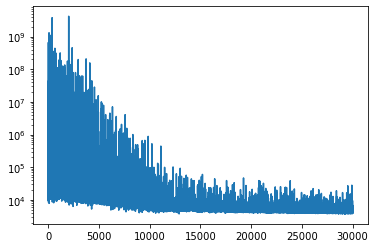

In [22]:
import matplotlib.pyplot as plt
plt.plot(approx.hist)
plt.yscale("log")

In [23]:
trace["dense2_w"].mean(axis=0)

array([[0.10940486],
       [0.10559317],
       [0.08672186],
       [0.12300616],
       [0.11916083],
       [0.11241376],
       [0.08635629]], dtype=float32)

In [24]:
with model:
    # pm.set_data(new_data={'As': As, 'Fs': Fs, 'Y': y})
    # ppc = pm.sample_posterior_predictive(trace, samples=500, progressbar=False, model=neural_network)
    samples = pm.sample_posterior_predictive(trace, samples=500)

100%|██████████| 500/500 [00:08<00:00, 60.34it/s]


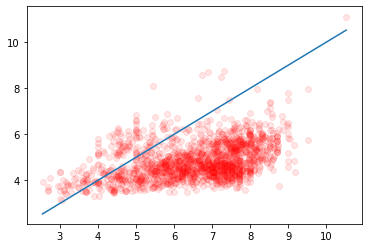

In [25]:
plt.scatter(y, samples["like"].mean(axis=0), color='red', alpha=0.1)


plt.plot([y.min(), y.max()], [y.min(), y.max()])

Not bad for training a teensy weensy neural network!

Let's see what the uncertainty looks like.

/home/ericmjl/anaconda/envs/fundl-dev/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  if sys.path[0] == '':


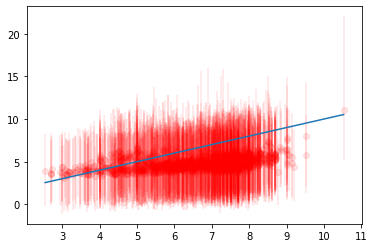

In [26]:
l, m, u = np.percentile(samples["like"], q=[25, 50, 75], axis=0)

ldiff = m - l
udiff = u - m

plt.errorbar(
    y, 
    samples["like"].mean(axis=0),
    yerr=[ldiff, udiff],
    fmt='none',
    color="red",
    alpha=0.1
)
plt.scatter(y, samples["like"].mean(axis=0), color='red', alpha=0.1)
plt.plot([y.min(), y.max()], [y.min(), y.max()])

One thing to note here is that the error model we have presumed is **homoskedastic**, i.e. equal variance on each sample. What would have been more principled would be to assume **heteroskedasticity**, i.e. non-equal variance per sample, and explicitly write a model to predict that variance.